In [45]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [46]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [47]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [48]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [49]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        # self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        # self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # self.batch2 = nn.BatchNorm2d(16)
        # self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # # out_width = (14-5)/2+1 = 5
        # #self.drop1=nn.Dropout2d(p=0.3) 
        # # 6 * 6 * 16 = 576
        # self.linear1 = nn.Linear(3*3*32, 128)
        # self.linear2 = nn.Linear(128, latent_dims)
        # self.linear3 = nn.Linear(128, latent_dims)

        self.zdim = latent_dims

        # construct the body
        body_list = []
        bl = nn.Linear(784, self.zdim * 2) 
        body_list.append(bl)
        il1 = nn.ReLU()
        body_list.append(il1)
        il2 = nn.Linear(self.zdim * 2, self.zdim * 2)
        body_list.append(il2)
        self.body = nn.Sequential(*body_list)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0



    def forward(self, x):
        #print(x.shape)
        x = x.to(device)

        scores = self.body(x)
        mu, sigma = torch.split(scores, self.zdim, dim=1)
        sigma = torch.exp(sigma)

        # initialise a tensor of normal distributions from tensors z_mu, z_sigma
        qz = torch.distributions.Normal(mu, sigma)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
        # sample from the distributions with re-parametrisation
        zs = qz.rsample()

        # x = F.relu(self.conv1(x))
        # x = F.relu(self.batch2(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # #print(x.shape)
        # x = torch.flatten(x, start_dim=1)
        # #print(x.shape)
        # x = F.relu(self.linear1(x))
        # mu =  self.linear2(x)
        # sigma = torch.exp(self.linear3(x))
        # z = mu + sigma*self.N.sample(mu.shape)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return zs

In [50]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        # ### Linear section
        # self.decoder_lin = nn.Sequential(
        #     # First linear layer
        #     nn.Linear(latent_dims, 128),
        #     nn.ReLU(True),
        #     # Second linear layer
        #     nn.Linear(128, 3 * 3 * 32),
        #     nn.ReLU(True)
        # )

        # ### Unflatten
        # self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # ### Convolutional section
        # self.decoder_conv = nn.Sequential(
        #     # First transposed convolution
        #     nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     # Second transposed convolution
        #     nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        #     nn.BatchNorm2d(8),
        #     nn.ReLU(True),
        #     # Third transposed convolution
        #     nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        # )

                # construct the body
        body_list = []
        bl = nn.Linear(latent_dims, 784)
        body_list.append(bl)

        il5 = nn.Sigmoid()
        body_list.append(il5)
        self.body = nn.Sequential(*body_list)

        
    def forward(self, x):
        # # Apply linear layers
        # x = self.decoder_lin(x)
        # # Unflatten
        # x = self.unflatten(x)
        # # Apply transposed convolutions
        # x = self.decoder_conv(x)
        # # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        # x = torch.sigmoid(x)
        mu = self.body(x)
 
        return mu

In [51]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [52]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (body): Sequential(
      (0): Linear(in_features=784, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (body): Sequential(
      (0): Linear(in_features=4, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)

## 3.Training

In [53]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [54]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [55]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [56]:
num_epochs = 10
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

RuntimeError: The size of tensor a (28) must match the size of tensor b (784) at non-singleton dimension 3

## 4.Generate samples

In [ ]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

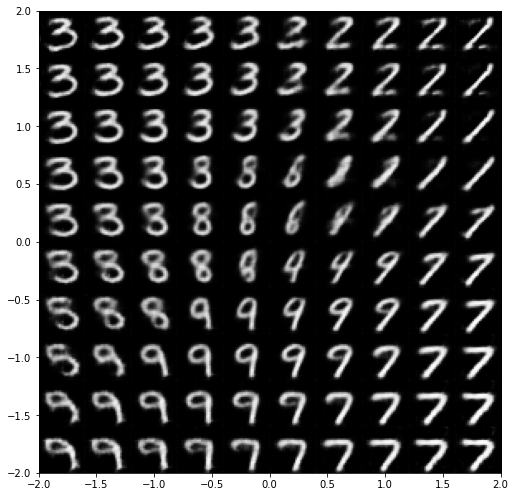

In [ ]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:09<00:00, 1032.80it/s]


In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,0.790741,-1.252131,-0.934510,0.590801,7
1,-0.221263,1.559616,-0.911835,0.967326,2
2,0.687043,0.022008,0.864768,1.567868,1
3,-0.179204,0.046168,-0.147385,-0.978159,0
4,-0.219730,-0.865538,-0.663269,-0.445289,4
...,...,...,...,...,...
9995,0.812000,0.873848,-1.403620,0.164043,2
9996,-1.111401,0.902999,-0.265921,0.241798,3
9997,0.522504,-0.413255,-0.238132,0.054317,4
9998,0.632160,-0.127326,1.469837,-0.707672,5


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()